### TTIC 31020 Introduction to Machine Learning: SVMs via subgradient descent
---
- The SVM learning problem is a convex optimization problem. It is presented either in its primal or dual form. The primal form is one of norm minimization subject to constraints, while the dual is a quadratic programming problem that is typically solved with an off-the-shelf QP solver. As a result, most popular machine learning libraries (e.g., LIBSVM underneath sklearn) solve the dual. In this assignment, you will solve the primal using subgradient descent, both the simple linear version and a version that supports nonlinear kernels. That is, we will solve the following optimization problem (we're not using the bias weight $b$ below):
\begin{equation*}
	\mathbf{w}^* = \arg\!\min \frac{\lambda}{2} ||\mathbf{w}||^2 + \frac{1}{n} \sum_{(\mathbf{x}, y) \in S} [\, 1 -  y(\mathbf{w} \cdot \mathbf{x}) \,]_+
\end{equation*}
where $ S $ is a train set of $ \{(\mathbf{x}_i, y_i)\}_{i=1}^n $. We use SGD with batch size 1.

In [1]:
import numpy as np
import numpy.random as npr

import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

import csv

In [2]:
def plot_decision_countour(svm, X, y, grid_size=100):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                         np.linspace(y_min, y_max, grid_size),
                         indexing='ij')
    data = np.stack([xx, yy], axis=2).reshape(-1, 2)
    pred = svm.predict(data).reshape(xx.shape)
    plt.contourf(xx, yy, pred,
                 cmap=cm.Paired,
                 levels=[-0.001, 0.001],
                 extend='both',
                 alpha=0.8)
    flatten = lambda m: np.array(m).reshape(-1,)
    plt.scatter(flatten(X[:, 0]), flatten(X[:, 1]),
                c=flatten(y), cmap=cm.Paired)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.plot()


def test_linear_SVM(svm, num_samples=500):
    """test linear svm
    """
    X = npr.random((num_samples, 2)) * 2 - 1
    y = 2 * (X.sum(axis=1) > 0) - 1.0

    svm.fit(X, y)
    plot_decision_countour(svm, X, y)


def test_rbf_SVM(svm, num_samples=500):
    """test rbf svm
    """
    X = npr.random((num_samples, 2)) * 2 - 1
    y = 2 * ((X ** 2).sum(axis=1) - 0.5 > 0) - 1.0

    svm.fit(X, y)
    plot_decision_countour(svm, X, y)


def compute_acc(model, X, y):
    pred = model.predict(X)
    size = len(y)
    num_correct = (pred == y).sum()
    acc = num_correct / float(size)
    print("{} out of {} correct, acc {:.3f}".format(num_correct, size, acc))

In [3]:
class LinearSVM():
    def __init__(self, lamb=1, num_epochs=20):
        """initialize the svm
        
        Args:
            lamb: the lambda parameter. Since lambda is a reserved keyword we use lamb
            num_epochs: number of epochs for training. T = data_size * num_epochs
        """
        self.w = None
        self.lamb = lamb
        self.num_epochs = num_epochs

    def fit(self, X, y):
        """Fit the model on the data
        
        Args:
            X: [N x d] data matrix
            y: [N, ] array of labels
        
        Returns:
            self, in case you want to build a pipeline
        """
        assert np.ndim(X) == 2, 'data matrix X expected to be 2d'
        assert np.ndim(y) == 1, 'labels expected to be 1d'
        N, d = X.shape
        assert N == y.shape[0], 'expect [N, d] data matrix and [N] labels'
        self.w = np.zeros(shape=(d,))
        T = int(self.num_epochs * N)
        lamb = self.lamb
        for t in range(1, T + 1):
            inx = npr.choice(N)
            lr = 1 / (lamb * t)
            x, lbl = X[inx], y[inx]

            margin = lbl * self.predict(x, binarize=False)
            if margin < 1:
                self.w = self.w + lr * (lbl * x - lamb * self.w)
            else:
                self.w = self.w - lr * lamb * self.w 
        print("fitting complete")
        return self

    def predict(self, X, binarize=True):
        """make a prediction and return either the confidence margin or label
        
        Args:
            X: [N, d] array of data or [d,] single data point
            binarize: if True, then return the label, else the confidence margin
        
        Returns:
            Either confidence margin or predicted label
        """
        if self.w is None:
            raise ValueError("go fit the data first")
        X = np.atleast_2d(X)
        assert X.shape[1] == self.w.shape[0]
        res = X @ self.w 
        res = res.squeeze()
        if binarize:
            return (2 * (res >= 0) - 1) 
        else:
            return res

    def clone(self):
        """construct a fresh copy of myself
        """
        return LinearSVM(self.lamb, self.num_epochs)

fitting complete


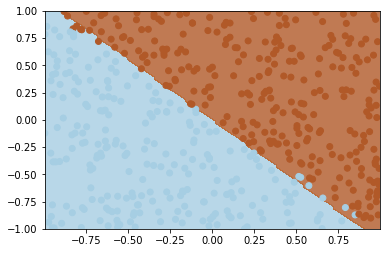

In [4]:
svm = LinearSVM(lamb=0.01, num_epochs=20)
test_linear_SVM(svm)

fitting complete


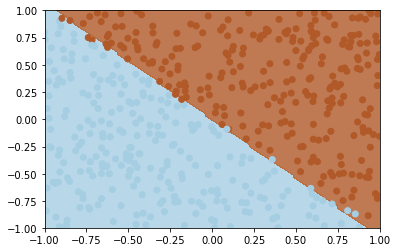

In [5]:
svm = LinearSVM(lamb=1, num_epochs=50)
test_linear_SVM(svm)

fitting complete


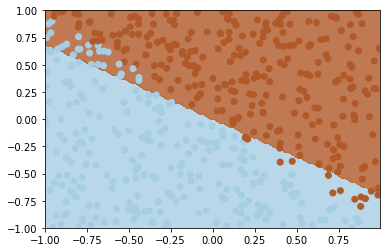

In [6]:
svm = LinearSVM(lamb=10, num_epochs=2)
test_linear_SVM(svm)

In [7]:
class Kernel(object):
    """A class containing a few kernels.
    
    
    Note that for each Kernel, the input comes in the form of 
    Args:
        X: [M, d]
        Y: [N, d]
    Returns:
        a matrix of shape [M, N] filled with kernel outputs
    """
    @staticmethod
    def linear():
        def f(X, Y):
            return X.dot(Y.T)
        return f

    @staticmethod
    def gaussian(gamma):
        def f(X, Y):
            # insert a new axis so that we can vectorize (with broadcasting)
            X = X[:, np.newaxis, :]
            exponent = (-gamma) * (np.linalg.norm(X - Y, 2, axis=2)) 
            return np.exp(exponent)
        return f

    @staticmethod
    def _poly(dimension, offset):
        def f(X, Y):
            return (offset + X.dot(Y.T)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(X, Y):
            return np.tanh(kappa * X.dot(Y.T) + c)
        return f

In [8]:
class KernelSVM():
    def __init__(self, kernel, lamb=1, num_epochs=20):
        """initialize the kernel svm
        
        Args:
            kernel: a kernel function
            lamb: the lambda parameter. Since lambda is a reserved keyword we use lamb
            num_epochs: number of epochs for training. T = data_size * num_epochs
        """
        self.num_epochs = num_epochs
        self.lamb = lamb
        assert callable(kernel), 'kernel should be a function'
        self.kernel = kernel
        self.repr_vec = None  # [K, d] of K (untransformed) representation vec
        self.repr_vec_lbls = None  # [K,] for the labels of the repr vec
        self.repr_vec_weights = None
        self.t = 1  # current step index. used by predict

    def fit(self, X, y):
        """Fit the model on the data
        
        Args:
            X: [N x d] data matrix
            y: [N, ] array of labels
        
        Returns:
            self, in case you want to build a pipeline
        """
        assert np.ndim(X) == 2, 'data matrix X expected to be 2d'
        assert np.ndim(y) == 1, 'labels expected to be 1d'
        N, d = X.shape
        assert N == y.shape[0], 'expect [N, d] data matrix and [N] labels'
        # initialize to dummies
        self.repr_vec             = np.zeros(shape=(1, d))
        self.repr_vec_lbls        = np.zeros(shape=(1,))
        self.repr_vec_weights     = np.zeros(shape=(1,))

        counts = np.zeros(shape=(N,))
        T = int(self.num_epochs * N)
        for t in range(1, T + 1):
            self.t = t
            inx = npr.choice(N)
            x, lbl = X[inx], y[inx]
            lr = 1.0 / (self.lamb * self.t)
            margin = lbl * lr * self.predict(x, binarize=False)
            if margin < 1:
                # update the counts
                counts[inx] = counts[inx] + 1
                self.repr_vec = X[np.where(counts!=0)]
                self.repr_vec_lbls = y[np.where(counts!=0)]
                self.repr_vec_weights = counts[np.where(counts!=0)]

        print("fitting complete")
        return self

    def predict(self, X, binarize=True):
        """make a prediction and return either the confidence margin or label
        
        Args:
            X: [N, d] array of data or [d,] single data point
            binarize: if True, then return the label, else the confidence margin
        
        Returns:
            Either confidence margin or predicted label
        """
        assert self.repr_vec is not None, 'go fit the data first'
        X = np.atleast_2d(X)
        if X.shape[0] > 50:
            # we want to avoid vectorization when N is too large. Why?
            # brave souls can try to remove this condition and see.
            ker_output = np.hstack([
                self.kernel(self.repr_vec, x.reshape(1, -1))
                for x in X
            ])
        else:
            ker_output = self.kernel(self.repr_vec, X)

        res = np.dot(self.repr_vec_weights * self.repr_vec_lbls, ker_output)
        res = res.squeeze()
        if binarize:
            # get labels from results
            lbls = 2 * (res >= 0) - 1
            return lbls
        else:
            return res

    def clone(self):
        """construct a fresh copy of myself
        """
        return KernelSVM(self.kernel, self.lamb, self.num_epochs)

fitting complete


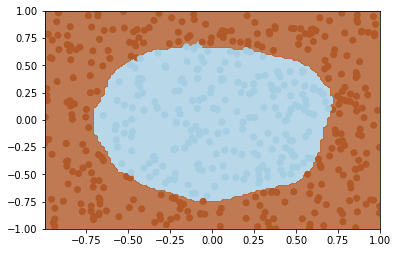

In [9]:
svm = KernelSVM(Kernel.gaussian(gamma=0.5), lamb=1e-4, num_epochs=20)
test_rbf_SVM(svm)

fitting complete


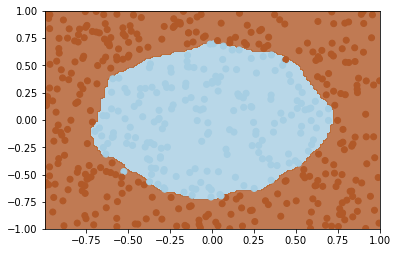

In [10]:
svm = KernelSVM(Kernel.gaussian(gamma=0.5), lamb=1e-4, num_epochs=60)
test_rbf_SVM(svm)

fitting complete


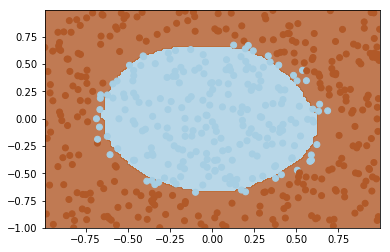

In [11]:
svm = KernelSVM(Kernel.gaussian(gamma=0.5), lamb=0.01, num_epochs=10)
test_rbf_SVM(svm)

#### Now that our SVM is working on the toy dataset, let's do sentiment analysis on [tweets on US airline service quality](https://www.kaggle.com/crowdflower/twitter-airline-sentiment/version/2). (WARNING: expletives unfiltered)
---
- As shown below, our data comes in the form of a csv table. The columns most relevant to our task are 'text' and 'airline_sentiment'.
- Data must be represented as a [N x d] matrix, but what we have on our hands is unstructured text.
- The simplest solution to transform an airline review into a vector is [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model). We maintain a global vocabulary of word patterns gathered from our corpus, with single words such as "great", "horrible", and optionally consecutive words (N-grams) like "friendly service", "luggage lost". Suppose we have already collected a total of 10000 such patterns, to transform a sentence into a 10000-dimensional vector, we simply scan it and look for the patterns that appear and set their corresponding entries to 1 and leave the rest at 0. What we end up with is a sparse vector that can be fed into SVMs.
- For this exercise we use the basic text processing routines in nltk and sklearn
- Our data is not balanced, with significant more negatives than neutral + positives. Therefore we group neutral and positive into one category and the final ratio of non-negative to negative is about 1:2. This is consistent across train, val, and test.

In [12]:
import os.path as osp
import pandas as pd
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [13]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
data_root = 'pset3-data'

In [16]:
train, val, test = \
    pd.read_csv(osp.join(data_root, 'train.csv')), \
    pd.read_csv(osp.join(data_root, 'val.csv')), \
    pd.read_csv(osp.join(data_root, 'devtest.csv'))

In [17]:
train.head(3)

,Unnamed: 0,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,3816,568103618500530176,neutral,1.0,NaN,NaN,United,NaN,willyvideo,NaN,0,@united #sfo #ClearVision #TV4U @ United Termi...,"[37.62006843, -122.38822083]",2015-02-18 09:43:52 -0800,NaN,Pacific Time (US & Canada)
1,10306,569379979055796224,negative,1.0,Customer Service Issue,0.6465,US Airways,NaN,PhilHagen,NaN,1,"@USAirways yes, i am as well. **FIVE** HOURS ...",NaN,2015-02-21 22:15:40 -0800,"Lewes, DE, USA",Eastern Time (US & Canada)
2,292,568840724700995584,negative,1.0,Flight Booking Problems,0.3895,Virgin America,NaN,notthatnathan,NaN,0,"@VirginAmerica Funny story, your website is br...",NaN,2015-02-20 10:32:51 -0800,"Portland, Maine",Eastern Time (US & Canada)


In [18]:
print(train.airline_sentiment.value_counts())

negative    5905
neutral     1804
positive    1442
Name: airline_sentiment, dtype: int64


In [19]:
# check these out 
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
def tokenize_normalize(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ", tweet)
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [20]:
# the sklearn vectorizer scans our corpus, build the vocabulary, and changes text into vectors
vectorizer = CountVectorizer(
    strip_accents='unicode', 
    lowercase=True, 
    tokenizer=tokenize_normalize,
    ngram_range=(1,1),  # you may want to try 2 grams. The vocab will get very large though
)
# first learn the vocabulary
vectorizer.fit(pd.concat([train, val, test]).text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_normalize at 0x00000185D6B7D9D8>,
        vocabulary=None)

In [21]:
# take a peek at the vocabulary learnt. We have the terms and the counts
print( list(vectorizer.vocabulary_.items())[:10] )
print("\n vocabulary size {}".format(len(vectorizer.vocabulary_)))

[('clearvision', 1531), ('tv', 9169), ('u', 9210), ('united', 9315), ('terminal', 8765), ('sfo', 7920), ('airport', 209), ('http', 4111), ('co', 1582), ('q', 7009)]

 vocabulary size 10250


In [22]:
X = {}
y = {}
X['train'] = vectorizer.transform(train.text).toarray()
X['val'] = vectorizer.transform(val.text).toarray()
X['test'] = vectorizer.transform(test.text).toarray()

# note that our data is 10250 dimensional. 
# This is a little daunting for laptops and coming up with a manageable vector representation is a major topic in Natural Language Processing.
print(X['train'].shape)

(9151, 10250)


In [23]:
# convert the word labels of 'positive', 'neutral', 'negative' into integer labels
# note that positive and neural belong to one category, labeled as 1, while negative stands alone as the other
for name, dataframe in zip(['train', 'val', 'test'], [train, val, test]):
    sentiments_in_words = dataframe['airline_sentiment'].tolist()
    int_lbls = np.array( list(map(lambda x: -1 if x == 'negative' else 1, sentiments_in_words)), dtype=np.int32 )
    y[name] = int_lbls

In [24]:
svm = LinearSVM(lamb=1e-3, num_epochs=25)
svm.fit(X['train'], y['train'])
compute_acc(svm, X['train'], y['train'])
compute_acc(svm, X['val'], y['val'])

fitting complete
8139 out of 9151 correct, acc 0.889
822 out of 1016 correct, acc 0.809


In [25]:
LAMB_VALS = [0.01, 1e-3, 1e-4]
EPOCH_VALS = [5, 15, 25]

for lamb in LAMB_VALS:
    for num_epochs in EPOCH_VALS:
        print('lamb = ', lamb)
        print('num_epochs = ', num_epochs)
        svm = LinearSVM(lamb, num_epochs)
        svm.fit(X['train'], y['train'])
        compute_acc(svm, X['train'], y['train'])
        compute_acc(svm, X['val'], y['val'])

lamb =  0.01
num_epochs =  5
fitting complete
7354 out of 9151 correct, acc 0.804
792 out of 1016 correct, acc 0.780
lamb =  0.01
num_epochs =  15
fitting complete
7343 out of 9151 correct, acc 0.802
796 out of 1016 correct, acc 0.783
lamb =  0.01
num_epochs =  25
fitting complete
7343 out of 9151 correct, acc 0.802
801 out of 1016 correct, acc 0.788
lamb =  0.001
num_epochs =  5
fitting complete
8085 out of 9151 correct, acc 0.884
817 out of 1016 correct, acc 0.804
lamb =  0.001
num_epochs =  15
fitting complete
8150 out of 9151 correct, acc 0.891
819 out of 1016 correct, acc 0.806
lamb =  0.001
num_epochs =  25
fitting complete
8117 out of 9151 correct, acc 0.887
823 out of 1016 correct, acc 0.810
lamb =  0.0001
num_epochs =  5
fitting complete
8328 out of 9151 correct, acc 0.910
824 out of 1016 correct, acc 0.811
lamb =  0.0001
num_epochs =  15
fitting complete
8624 out of 9151 correct, acc 0.942
795 out of 1016 correct, acc 0.782
lamb =  0.0001
num_epochs =  25
fitting complete
869

- Try to come up with a better text feature representation. We threw out all the emojis. >< what a waste
- Given the high feature dimensionality of our primitive text processing, we do not recommend using kernel SVM here. It could take a long time to train. If you reduce the feature dimensionality, then it's a different story
- Play around with different parameter settings and find the best setting on the validation set, then evaluate on the devtest set when you're finished tuning.

I tried running different kernels for the  dataset and it too long to fit so I gave up, sorry :(. But the best hyperparameter values for lambda and num_epochs (as seen above) is 1e-3 and 15 respectively (based on the validation accuracy). So I choose my final model to have the same hyperparameter values. 

In [26]:
svm = LinearSVM(lamb=1e-3, num_epochs=15)
svm.fit(X['train'], y['train'])
compute_acc(svm, X['train'], y['train'])
compute_acc(svm, X['val'], y['val'])

fitting complete
8135 out of 9151 correct, acc 0.889
825 out of 1016 correct, acc 0.812


In [27]:
compute_acc(svm, X['test'], y['test'])

798 out of 984 correct, acc 0.811


There is no large gap in accuracy between the validation set and the dev (test) set, so I infer that the model is mostly not overfitting the train data.